In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip '/content/drive/MyDrive/lfw.zip'

Streaming output truncated to the last 5000 lines.
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0021.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0021.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0020.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0020.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0008.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0008.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0022.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0022.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0023.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0023.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0012.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0012.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep

In [4]:
path = '/content/lfw'

In [5]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [6]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([250, 250, 3])


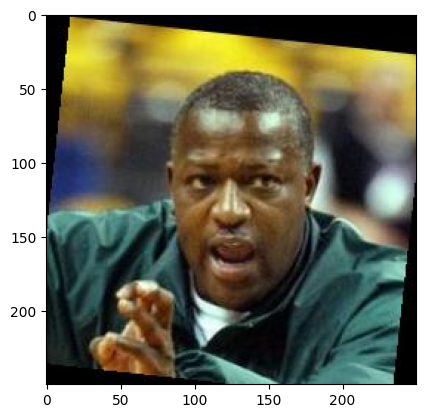

In [7]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()

        # Encoder layers
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # [batch, 32, 32, 32]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # [batch, 64, 16, 16]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # [batch, 128, 8, 8]
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # [batch, 256, 4, 4]
            nn.ReLU(),
            nn.Flatten(),  # [batch, 4096]
        )
        self.fc_mean = nn.Linear(4096, latent_dim)
        self.fc_logvar = nn.Linear(4096, latent_dim)

        # Decoder layers
        self.fc_decoder = nn.Linear(latent_dim, 4096)
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # [batch, 128, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # [batch, 64, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # [batch, 32, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # [batch, 3, 64, 64]
            nn.Sigmoid(),  # Ensure the output values are in the range [0, 1]
        )

    def encode(self, x):
        x = self.encoder_conv(x)
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std)
        return mean + epsilon * std

    def decode(self, z):
        z = self.fc_decoder(z)
        z = z.view(-1, 256, 4, 4)
        return self.decoder_conv(z)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar


## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

In [87]:
# Create an instance of the model
latent_dim = 20  # Assuming we are using a latent dimension of 20
conv_vae_model = ConvVAE(latent_dim=latent_dim)

In [88]:
# Print the model to check the architecture
print(conv_vae_model)

ConvVAE(
  (encoder_conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mean): Linear(in_features=4096, out_features=20, bias=True)
  (fc_logvar): Linear(in_features=4096, out_features=20, bias=True)
  (fc_decoder): Linear(in_features=20, out_features=4096, bias=True)
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv

In [ ]:
# # Assuming you have an image file named 'sample_image.jpg'
# image_path = '/content/lfw/Abdel_Aziz_Al-Hakim/Abdel_Aziz_Al-Hakim_0001.jpg'

In [90]:
from torchvision import transforms
from PIL import Image

# Path to an image file
image_path = '/content/lfw/Abdel_Aziz_Al-Hakim/Abdel_Aziz_Al-Hakim_0001.jpg'

# Define the transformations to preprocess the image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to the size required by the model
    transforms.ToTensor()  # Convert the image to a PyTorch tensor
])

# Load the image using PIL, make sure to open it in RGB mode
image = Image.open(image_path).convert('RGB')

# Apply the transformations to the image
image_tensor = transform(image).unsqueeze(0)  # Add a batch dimension with unsqueeze

# Instantiate the VAE model with the appropriate latent_dim
latent_dim = 20  # Assuming a latent space dimension of 20
model = ConvVAE(latent_dim=latent_dim)

# Pass the image tensor through the VAE
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to track gradients for inference
    output_reconstructed, mean, logvar = model(image_tensor)

# Print the shape of the encoder's output
print("Mean shape:", mean.shape)
print("LogVar shape:", logvar.shape)

# Generate a new sample in the latent space
sampled_latent = model.reparameterize(mean, logvar)

# Use the decode method to create a new image from the sampled latent vector
generated_image = model.decode(sampled_latent)

# Print the shape of the decoder's output
print("Generated image shape:", generated_image.shape)



Mean shape: torch.Size([1, 20])
LogVar shape: torch.Size([1, 20])
Generated image shape: torch.Size([1, 3, 64, 64])


##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

In [ ]:
optim =

In [ ]:
loss_function =

In [91]:
# Print the total number of parameters in the model
total_params = sum(p.numel() for p in model.parameters())
print("Total Number of Parameters:", total_params)

# Loss function for VAE:
# The loss function for a VAE consists of two main terms: reconstruction loss and regularization loss (Kullback-Leibler divergence).

# Reconstruction Loss:
reconstruction_loss = F.binary_cross_entropy(output_reconstructed, image.view(-1, input_dim), reduction='sum')

# Regularization Loss (Kullback-Leibler Divergence):
kl_divergence_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

# Total Loss:
total_loss = reconstruction_loss + kl_divergence_loss

# Explanation of the terms:
# 1. Reconstruction Loss: This term measures how well the VAE is able to reconstruct the input data. It penalizes differences between the reconstructed output and the original input. The goal is to minimize this loss to ensure accurate reconstructions.
# 2. Kullback-Leibler Divergence: This term acts as a regularization term. It encourages the distribution of the latent space to be close to a standard normal distribution. The goal is to prevent overfitting and ensure a well-structured latent space that facilitates meaningful sampling and generation of new data.

# Create an optimizer for training
learning_rate = 0.001  # Adjust based on your preferences
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


Total Number of Parameters: 1629931


AttributeError: ignored

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [92]:
def vae_loss(reconstructed_x, original_x, mean, logvar):
    # Reconstruction loss (use MSE or BCE depending on the final layer activation)
    reconstruction_loss = F.binary_cross_entropy(reconstructed_x.view(-1, 3*64*64), original_x.view(-1, 3*64*64), reduction='sum')

    # KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

    return reconstruction_loss + kl_divergence

# Number of training epochs
num_epochs = 10

# Set the desired dimensions for resizing
desired_height = 64  # 64x64 image
desired_width = 64

# Instantiate and configure the optimizer
optimizer = Adam(conv_vae_model.parameters(), lr=1e-3)

# Training loop
for epoch in range(num_epochs):
    conv_vae_model.train()  # Set the model to training mode
    total_loss_epoch = 0

    for batch_data, _ in dataloader:
        # Resize images to a consistent size, retain the color channels
        batch_data_resized = F.interpolate(batch_data, size=(desired_height, desired_width), mode='bilinear')

        # Forward pass through the VAE model
        output_reconstructed, mean, logvar = conv_vae_model(batch_data_resized)

        # Prepare target data by resizing
        target_resized = F.interpolate(batch_data, size=(desired_height, desired_width), mode='bilinear')

        # Zero the gradients before backward pass
        optimizer.zero_grad()

        # Calculate the loss
        loss = vae_loss(output_reconstructed, target_resized, mean, logvar)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the loss for this batch
        total_loss_epoch += loss.item()

    # Calculate the average loss for the epoch
    average_loss_epoch = total_loss_epoch / len(dataloader.dataset)

    # Report the loss at the end of each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss_epoch}")


Epoch [1/10], Loss: 6918.365504834933
Epoch [2/10], Loss: 6485.504654330664
Epoch [3/10], Loss: 6446.810171064063
Epoch [4/10], Loss: 6424.659692646559
Epoch [5/10], Loss: 6412.184151195513
Epoch [6/10], Loss: 6400.0051713473595
Epoch [7/10], Loss: 6388.40310776611
Epoch [8/10], Loss: 6372.2770589776765
Epoch [9/10], Loss: 6361.64725886719
Epoch [10/10], Loss: 6353.313186994787


##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

In [93]:
# Save the trained model
model_path = 'conv_vae_model.pth'
torch.save(conv_vae_model.state_dict(), model_path)

In [94]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def plot_images(images, title):
    # Arrange images in a grid
    images = make_grid(images.detach().cpu(), nrow=8, normalize=True)

    # Plot the images
    plt.imshow(images.permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')
    plt.show()




model_path = 'vae_model.pth'
try:
    conv_vae_model.load_state_dict(torch.load(model_path))
    conv_vae_model.eval()
except Exception as e:
    print(f"Error loading the model: {e}")

# Choose a random image from the dataset
random_index = random.randint(0, len(dataloader.dataset) - 1)
random_image, _ = dataloader.dataset[random_index]

# Convert the tensor to a PIL Image and preprocess it
random_image_pil = transforms.ToPILImage()(random_image)
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to 64x64
    transforms.ToTensor()  # Keep RGB channels
])
random_image = transform(random_image_pil).unsqueeze(0)

# Forward pass through the first layer
try:
    output_first_layer = conv_vae_model.encoder(random_image.view(1, -1))
except Exception as e:
    print(f"Error during forward pass through the first layer: {e}")



Error loading the model: Error(s) in loading state_dict for ConvVAE:
	Missing key(s) in state_dict: "encoder_conv.0.weight", "encoder_conv.0.bias", "encoder_conv.2.weight", "encoder_conv.2.bias", "encoder_conv.4.weight", "encoder_conv.4.bias", "encoder_conv.6.weight", "encoder_conv.6.bias", "fc_decoder.weight", "fc_decoder.bias", "decoder_conv.0.weight", "decoder_conv.0.bias", "decoder_conv.2.weight", "decoder_conv.2.bias", "decoder_conv.4.weight", "decoder_conv.4.bias", "decoder_conv.6.weight", "decoder_conv.6.bias". 
	Unexpected key(s) in state_dict: "fc1.weight", "fc1.bias", "fc3.weight", "fc3.bias", "fc4.weight", "fc4.bias". 
	size mismatch for fc_mean.weight: copying a param with shape torch.Size([20, 512]) from checkpoint, the shape in current model is torch.Size([20, 4096]).
	size mismatch for fc_logvar.weight: copying a param with shape torch.Size([20, 512]) from checkpoint, the shape in current model is torch.Size([20, 4096]).
Error during forward pass through the first layer:

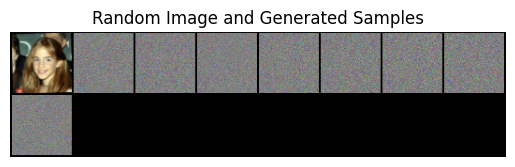

In [63]:
# Assume num_samples is the number of samples you want to generate
num_samples = 8
latent_dim = 20  # or whatever the latent dimension of your model is

# Generate random latent vectors
random_latent_vectors = torch.randn(num_samples, latent_dim)

# Generate images from the latent vectors
with torch.no_grad():
    vae_model.eval()  # Ensure the model is in evaluation mode
    generated_images = vae_model.decoder(random_latent_vectors).cpu()

# Reshape the generated images if necessary
# The shape should be [num_samples, channels, height, width]
# For 64x64 RGB images, this would be [num_samples, 3, 64, 64]
generated_images = generated_images.view(num_samples, 3, 64, 64)

# Clamp the values of the generated images to the range [0, 1] for valid image display
generated_images = torch.clamp(generated_images, 0, 1)

# Now concatenate with random_image for visualization
concatenated_images = torch.cat([random_image, generated_images], dim=0)

# Plot the images
plot_images(concatenated_images, "Random Image and Generated Samples")


In [59]:
print(vae_model)


VAE(
  (fc1): Linear(in_features=12288, out_features=512, bias=True)
  (fc_mean): Linear(in_features=512, out_features=20, bias=True)
  (fc_logvar): Linear(in_features=512, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=12288, bias=True)
)


In [60]:
print(generated_images.size())


torch.Size([8, 12288])


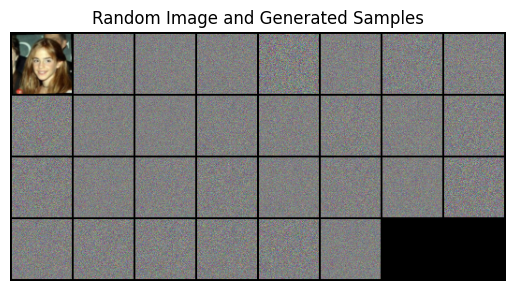

In [61]:
# Assume the output_reconstructed and generated_images are in the batch format with the correct number of samples
# Reshape the output tensors to match the RGB image dimensions
output_reconstructed_reshaped = output_reconstructed.view(-1, 3, desired_height, desired_width)
generated_images_reshaped = generated_images.view(-1, 3, desired_height, desired_width)

# Concatenate the tensors along the batch dimension for visualization
# Ensure random_image also has the same shape
random_image_reshaped = random_image.view(-1, 3, desired_height, desired_width)
concatenated_images = torch.cat([random_image_reshaped, output_reconstructed_reshaped, generated_images_reshaped], dim=0)

# Plot the images
plot_images(concatenated_images, "Random Image and Generated Samples")


In [62]:
plt.imshow()

TypeError: ignored